In [2]:
# Setup: imports, optional installs, config
import sys, json, os, random

try:
    import pandas as pd  # type: ignore
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns  # type: ignore
except ImportError:
    # Install minimal deps inside the notebook kernel
    %pip -q install pandas matplotlib seaborn
    import pandas as pd  # type: ignore
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns  # type: ignore

# Plot style and reproducibility
sns.set(style="whitegrid")
random.seed(42)
np.random.seed(42)

DATA_PATH = os.path.join("data", "merged_data_combined.json")
assert os.path.exists(DATA_PATH), f"Missing data file: {DATA_PATH}"



In [3]:
# Load data into DataFrame
with open(DATA_PATH, "r", encoding="utf-8") as f:
    raw = json.load(f)

assert isinstance(raw, list), "Expected a list of records"

df = pd.DataFrame(raw)
print(f"Rows: {len(df):,} | Columns: {len(df.columns)}")
df.head(3)


Rows: 1,500 | Columns: 6


,ID,Understand the text?,Offensive/Inappropriate?,Is a Joke?,Funniness (1-5),text
0,hom_362,0.8,0.25,0.4,0.6,"Be true to your teeth , or they will be false ..."
1,hom_1510,1.0,0.00,0.8,1.6,The inventor of sandpaper had a rough time of ...
2,hom_1505,0.6,0.00,0.4,0.4,When you can ' t decide with your friends whos...


In [4]:
# Overview: columns, dtypes, missingness
print(df.dtypes)
print("\nMissing values per column:")
print(df.isna().sum().sort_values(ascending=False))

# Basic stats for numeric columns
num_cols = df.select_dtypes(include=["number"]).columns.tolist()
print("\nNumeric columns:", num_cols)
df[num_cols].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])


ID                           object
Understand the text?        float64
Offensive/Inappropriate?    float64
Is a Joke?                  float64
Funniness (1-5)             float64
text                         object
dtype: object

Missing values per column:
ID                          0
Understand the text?        0
Offensive/Inappropriate?    0
Is a Joke?                  0
Funniness (1-5)             0
text                        0
dtype: int64

Numeric columns: ['Understand the text?', 'Offensive/Inappropriate?', 'Is a Joke?', 'Funniness (1-5)']


,Understand the text?,Offensive/Inappropriate?,Is a Joke?,Funniness (1-5)
count,1500.000000,1500.000000,1500.000000,1500.000000
mean,0.824400,0.053727,0.696000,1.163600
std,0.215272,0.171884,0.297034,0.606113
min,0.000000,0.000000,0.000000,0.000000
10%,0.600000,0.000000,0.200000,0.400000
25%,0.800000,0.000000,0.600000,0.800000
50%,0.800000,0.000000,0.800000,1.200000
75%,1.000000,0.000000,1.000000,1.600000
90%,1.000000,0.200000,1.000000,2.000000
max,1.000000,2.250000,1.000000,3.400000


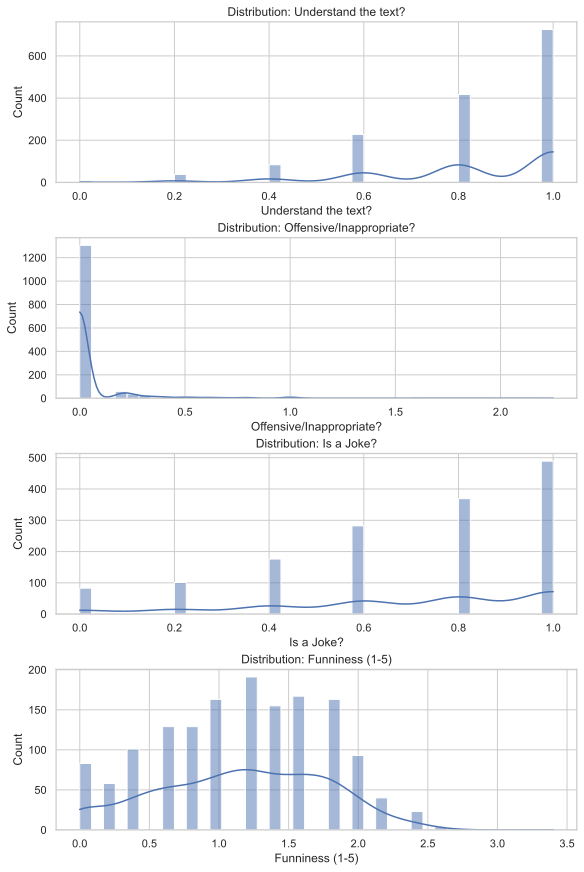

In [5]:
# Distributions for numeric fields
fig, axes = plt.subplots(len(num_cols), 1, figsize=(8, 3*len(num_cols)), constrained_layout=True)
if len(num_cols) == 1:
    axes = [axes]
for ax, col in zip(axes, num_cols):
    sns.histplot(df[col].dropna(), kde=True, ax=ax, bins=40)
    ax.set_title(f"Distribution: {col}")
plt.show()


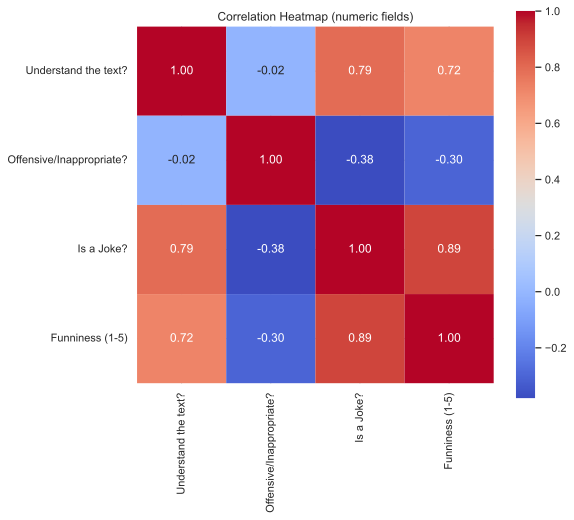

In [6]:
# Correlation heatmap among numeric columns
corr = df[num_cols].corr(numeric_only=True)
plt.figure(figsize=(6 + 0.5*len(num_cols), 5 + 0.5*len(num_cols)))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar=True)
plt.title("Correlation Heatmap (numeric fields)")
plt.show()


In [7]:
# Sample jokes across funniness levels
fun_col_candidates = [c for c in df.columns if c.lower().startswith("funniness")]
FUN_COL = fun_col_candidates[0] if fun_col_candidates else "Funniness (1-5)"
print("Using funniness column:", FUN_COL)

# Create bins on the native 1–5 scale (as present in the file)
# We'll define low/mid/high buckets and sample a few examples from each
bins = [0, 1, 2, 3, 4, 5.0001]
labels = ["0–1", "1–2", "2–3", "3–4", "4–5"]

if FUN_COL not in df.columns:
    raise ValueError("Could not locate funniness column in data")

bucketed = df.assign(_bucket=pd.cut(df[FUN_COL], bins=bins, labels=labels, include_lowest=True))

# Helper to pretty-print a few examples per bucket
def sample_examples(frame, bucket_label, k=5):
    subset = frame[frame["_bucket"] == bucket_label]
    if subset.empty:
        return []
    # Prefer text-like column names
    text_col = None
    for cand in ["text", "joke", "content", "sentence"]:
        if cand in subset.columns:
            text_col = cand
            break
    if text_col is None:
        text_col = subset.columns[-1]
    return subset[[text_col, FUN_COL]].sample(min(k, len(subset)), random_state=42).values.tolist()

for lab in labels:
    examples = sample_examples(bucketed, lab, k=5)
    print(f"\n=== Examples for bucket {lab} ===")
    for text, score in examples:
        print(f"[{score:.2f}] {text}")


Using funniness column: Funniness (1-5)

=== Examples for bucket 0–1 ===
[0.40] His affection for her was more than a passion interest .
[1.00] When the waiter told me they were out of corn I said , ' That really shucks . '
[0.80] It was such a big piece of gold , he didn ' t know what to assay .
[0.20] Epitaphs are engraved !
[0.40] OLD ACTUARIES never die they just get broken down by age and sex .

=== Examples for bucket 1–2 ===
[1.20] ' ' I just bought a woollen sweater , ' ' said Tom sheepishly .
[1.20] I crossed a cell phone with a skunk , and now the service stinks .
[1.20] To kill a circus in one blow , go for the juggler .
[1.60] My wife uses a kitchen implement to shred garlic and parmesan cheese , which I hate . It really is the grater of two evils .
[1.60] One ear of corn said to the other ' You ' re getting husky ' .

=== Examples for bucket 2–3 ===
[2.20] Animals that tunnel in the soil have to have an escape root .
[2.40] A book called ' Current Trends in Wiring your Hou